### Exploratory Data Analysis (EDA)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC

In [4]:
df = pd.read_csv("C:/Users/deyna/Desktop/anomaly-fl-main/data/small_df.csv")

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,balance_delta,large_transaction
0,367,CASH_OUT,972009.75,C961270274,972009.75,0.00,C1692249598,298095.31,1270105.06,1,0,7,972009.75,True
1,210,TRANSFER,182417.23,C1791585479,0.00,0.00,C1376183040,1002955.42,1185372.65,0,0,18,0.00,False
2,226,CASH_OUT,223763.08,C1537801609,0.00,0.00,C2058014912,359801.68,583564.75,0,0,10,0.00,True
3,261,CASH_OUT,89120.05,C1922744585,0.00,0.00,C1000322805,148643.27,237763.32,0,0,21,0.00,False
4,372,CASH_IN,20869.84,C309880556,16504703.57,16525573.41,C2052522327,7084245.06,7063375.22,0,0,12,-20869.84,False



    - step: Represents a unit of time in the real world, with 1 step equating to 1 hour. The total simulation spans 744 steps, equivalent to 30 days.
    - type: Transaction types include CASH-IN, CASH-OUT, DEBIT, PAYMENT, and TRANSFER. 
        
        - CASH-IN is the process of increasing the balance of account by paying in cash to a merchant. 
        - CASH-OUT is the opposite process of CASH-IN, it means to withdraw cash from a merchant which decreases the balance of the account.
        - DEBIT is similar process than CASH-OUT and involves sending the money from the mobile money service to a bank account.
        - PAYMENT is the process of paying for goods or services to merchants which decreases the balance of the account and increases the balance of the receiver.
        - TRANSFER is the process of sending money to another user of the service through the mobile money platform.
    
    - amount: The transaction amount in the local currency.
    - nameOrig: The customer initiating the transaction.
    - oldbalanceOrg: The initial balance before the transaction.
    - newbalanceOrig: The new balance after the transaction.
    - nameDest: The transaction's recipient customer.
    - oldbalanceDest: The initial recipient's balance before the transaction. Not applicable for customers identified by 'M' (Merchants).
    - newbalanceDest: The new recipient's balance after the transaction. Not applicable for 'M' (Merchants).
    - isFraud: Identifies transactions conducted by fraudulent agents aiming to deplete customer accounts through transfers and cash-outs.
    - isFlaggedFraud: Flags large-scale, unauthorized transfers between accounts, with any single transaction exceeding 200,000 being considered illegal.


References: https://www.researchgate.net/publication/313138956_PAYSIM_A_FINANCIAL_MOBILE_MONEY_SIMULATOR_FOR_FRAUD_DETECTION, https://www.kaggle.com/datasets/sriharshaeedala/financial-fraud-detection-dataset/data


In [8]:
df.shape

(5694, 14)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5694 entries, 0 to 5693
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   step               5694 non-null   int64  
 1   type               5694 non-null   object 
 2   amount             5694 non-null   float64
 3   nameOrig           5694 non-null   object 
 4   oldbalanceOrg      5694 non-null   float64
 5   newbalanceOrig     5694 non-null   float64
 6   nameDest           5694 non-null   object 
 7   oldbalanceDest     5694 non-null   float64
 8   newbalanceDest     5694 non-null   float64
 9   isFraud            5694 non-null   int64  
 10  isFlaggedFraud     5694 non-null   int64  
 11  hour               5694 non-null   int64  
 12  balance_delta      5694 non-null   float64
 13  large_transaction  5694 non-null   bool   
dtypes: bool(1), float64(6), int64(4), object(3)
memory usage: 584.0+ KB


In [183]:
df.nunique()

step                  736
type                    5
amount               5598
nameOrig             5694
oldbalanceOrg        4571
newbalanceOrig       1257
nameDest             5653
oldbalanceDest       4584
newbalanceDest       4528
isFraud                 2
isFlaggedFraud          1
hour                   24
balance_delta        4587
large_transaction       2
dtype: int64

In [184]:
df.isnull().sum()

step                 0
type                 0
amount               0
nameOrig             0
oldbalanceOrg        0
newbalanceOrig       0
nameDest             0
oldbalanceDest       0
newbalanceDest       0
isFraud              0
isFlaggedFraud       0
hour                 0
balance_delta        0
large_transaction    0
dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,5694.0,3.045248e+02,1.932009e+02,1.0,160.0000,282.000,4.070000e+02,7.430000e+02
amount,5694.0,8.003949e+05,1.800420e+06,0.0,33244.0500,169044.280,5.357173e+05,1.000000e+07
oldbalanceOrg,5694.0,1.112454e+06,2.523222e+06,0.0,9191.5000,113935.595,7.745531e+05,2.967292e+07
newbalanceOrig,5694.0,4.088762e+05,1.939883e+06,0.0,0.0000,0.000,0.000000e+00,2.991753e+07
oldbalanceDest,5694.0,1.311359e+06,4.255175e+06,0.0,30937.0525,305218.915,1.236228e+06,2.362305e+08
newbalanceDest,5694.0,2.085434e+06,4.681523e+06,0.0,126171.1325,759736.105,2.385305e+06,2.367265e+08
isFraud,5694.0,5.000000e-01,5.000439e-01,0.0,0.0000,0.500,1.000000e+00,1.000000e+00
isFlaggedFraud,5694.0,0.000000e+00,0.000000e+00,0.0,0.0000,0.000,0.000000e+00,0.000000e+00
hour,5694.0,1.347734e+01,6.054623e+00,0.0,10.0000,14.000,1.800000e+01,2.300000e+01
balance_delta,5694.0,7.035778e+05,1.820968e+06,-830317.4,0.0000,31143.380,4.311981e+05,1.000000e+07


##### Summary statistics for fraudulent transactions

In [11]:
df[df['isFraud'] == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
step,2847.0,3.656231e+02,2.163470e+02,1.00,176.000,365.00,554.000,7.430000e+02
amount,2847.0,1.436415e+06,2.355400e+06,0.00,126969.980,428174.70,1533014.100,1.000000e+07
oldbalanceOrg,2847.0,1.434453e+06,2.356194e+06,0.00,124639.780,426323.38,1525000.600,1.000000e+07
newbalanceOrig,2847.0,2.605147e+02,1.001132e+04,0.00,0.000,0.00,0.000,4.429177e+05
oldbalanceDest,2847.0,1.569920e+06,5.523522e+06,3.51,124850.630,419490.33,1419093.910,2.362305e+08
newbalanceDest,2847.0,3.018190e+06,5.994589e+06,4555.92,554010.375,1424569.93,3679861.635,2.367265e+08
isFraud,2847.0,1.000000e+00,0.000000e+00,1.00,1.000,1.00,1.000,1.000000e+00
isFlaggedFraud,2847.0,0.000000e+00,0.000000e+00,0.00,0.000,0.00,0.000,0.000000e+00
hour,2847.0,1.155778e+01,6.867592e+00,0.00,6.000,12.00,17.000,2.300000e+01
balance_delta,2847.0,1.434192e+06,2.356264e+06,0.00,124447.075,426323.38,1525000.600,1.000000e+07


##### Summary statistics for non-fraudulent transactions

In [13]:
df[df['isFraud'] == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
step,2847.0,2.434264e+02,1.427992e+02,2.0,155.00,239.00,345.500,717.00
amount,2847.0,1.643751e+05,3.562741e+05,13.5,11818.38,68835.30,203177.695,9193602.45
oldbalanceOrg,2847.0,7.904552e+05,2.641296e+06,0.0,0.00,11453.00,100956.500,29672916.27
newbalanceOrig,2847.0,8.174919e+05,2.682063e+06,0.0,0.00,0.00,149375.355,29917526.51
oldbalanceDest,2847.0,1.052798e+06,2.361431e+06,0.0,0.00,160793.11,1067613.880,36892930.48
newbalanceDest,2847.0,1.152677e+06,2.482987e+06,0.0,0.00,216053.60,1224297.465,37174736.58
isFraud,2847.0,0.000000e+00,0.000000e+00,0.0,0.00,0.00,0.000,0.00
isFlaggedFraud,2847.0,0.000000e+00,0.000000e+00,0.0,0.00,0.00,0.000,0.00
hour,2847.0,1.539691e+01,4.335195e+00,0.0,12.00,16.00,19.000,23.00
balance_delta,2847.0,-2.703669e+04,1.142857e+05,-830317.4,0.00,0.00,8073.925,838620.63


Replacing zero balances with NaN for specific transaction types like TRANSFER and CASH_OUT can be a useful step, especially if a zero balance is not a valid or meaningful value for these transactions. This can help in avoiding any misleading analyses or incorrect model training. 

In [12]:
# Replace '0.0' balances with NaN for TRANSFER transactions
df.loc[(df['type'] == 'TRANSFER') & (df['oldbalanceDest'] == 0), 'oldbalanceDest'] = None
df.loc[(df['type'] == 'TRANSFER') & (df['newbalanceDest'] == 0), 'newbalanceDest'] = None

# Replace '0.0' balances with NaN for CASH_OUT transactions
df.loc[(df['type'] == 'CASH_OUT') & (df['oldbalanceDest'] == 0), 'oldbalanceDest'] = None
df.loc[(df['type'] == 'CASH_OUT') & (df['newbalanceDest'] == 0), 'newbalanceDest'] = None

In [13]:
df.isnull().sum()

step                 0
type                 0
amount               0
nameOrig             0
oldbalanceOrg        0
newbalanceOrig       0
nameDest             0
oldbalanceDest       0
newbalanceDest       0
isFraud              0
isFlaggedFraud       0
hour                 0
balance_delta        0
large_transaction    0
dtype: int64

In [14]:
df.dropna(inplace=True)

#### Visualizations

##### Plotting the count of type of transactions

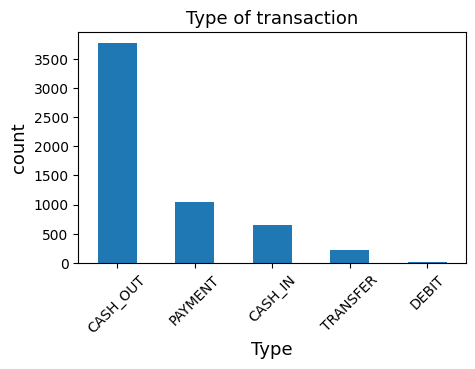

In [15]:
plt.figure(figsize = (5,3))
df['type'].value_counts().plot(kind = 'bar')
plt.title('Type of transaction', fontsize = 13)
plt.xticks(rotation = 45)
plt.xlabel('Type', fontsize = 13)
plt.ylabel('count', fontsize = 13)
plt.show()

##### Transaction amount

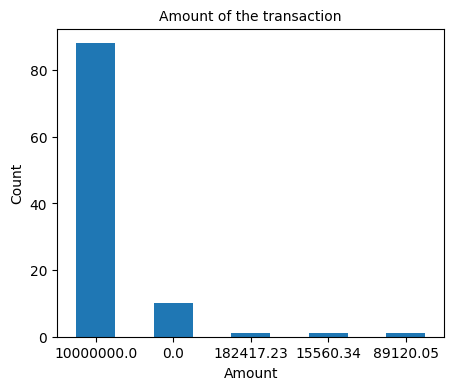

In [16]:
plt.figure(figsize = (5,4))
df['amount'].value_counts().sort_values(ascending = False).head().plot(kind = 'bar')
plt.title("Amount of the transaction", fontsize = 10)
plt.xticks(rotation = 0, fontsize = 10)
plt.xlabel('Amount', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.show()

In [17]:
df_synt = df[df['amount'] != 0.0]

In [18]:
df_synt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5684 entries, 0 to 5693
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   step               5684 non-null   int64  
 1   type               5684 non-null   object 
 2   amount             5684 non-null   float64
 3   nameOrig           5684 non-null   object 
 4   oldbalanceOrg      5684 non-null   float64
 5   newbalanceOrig     5684 non-null   float64
 6   nameDest           5684 non-null   object 
 7   oldbalanceDest     5684 non-null   float64
 8   newbalanceDest     5684 non-null   float64
 9   isFraud            5684 non-null   int64  
 10  isFlaggedFraud     5684 non-null   int64  
 11  hour               5684 non-null   int64  
 12  balance_delta      5684 non-null   float64
 13  large_transaction  5684 non-null   bool   
dtypes: bool(1), float64(6), int64(4), object(3)
memory usage: 627.2+ KB


##### Fraud rate per transaction type

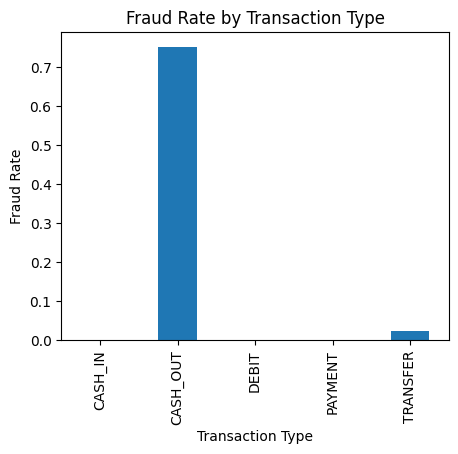

In [73]:
plt.figure(figsize = (5,4))
fraud_rate = df_synt.groupby('type')['isFraud'].mean()
fraud_rate.plot(kind='bar')
plt.title('Fraud Rate by Transaction Type')
plt.ylabel('Fraud Rate')
plt.xlabel('Transaction Type')
plt.show()


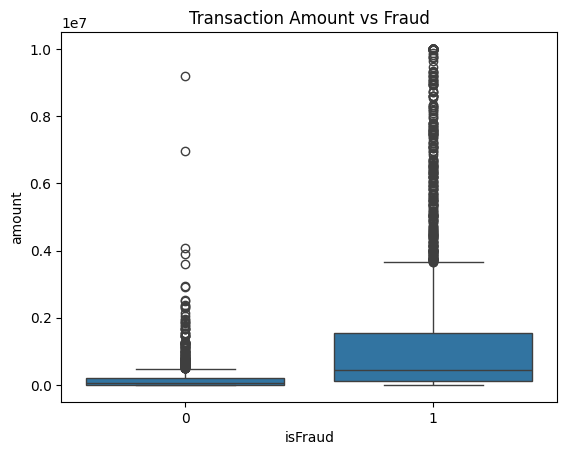

In [25]:
# Relationship between transaction amount and fraud
sns.boxplot(x='isFraud', y='amount', data=df_synt)
plt.title('Transaction Amount vs Fraud')
plt.show()

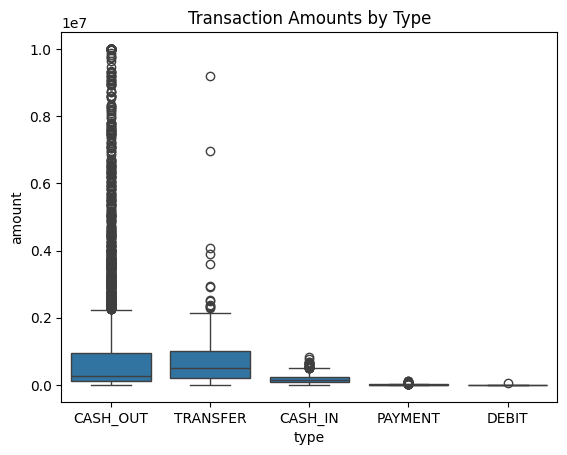

In [168]:
# Distribution of transaction amounts by type
sns.boxplot(x='type', y='amount', data=df_synt)
plt.title('Transaction Amounts by Type')
plt.show()

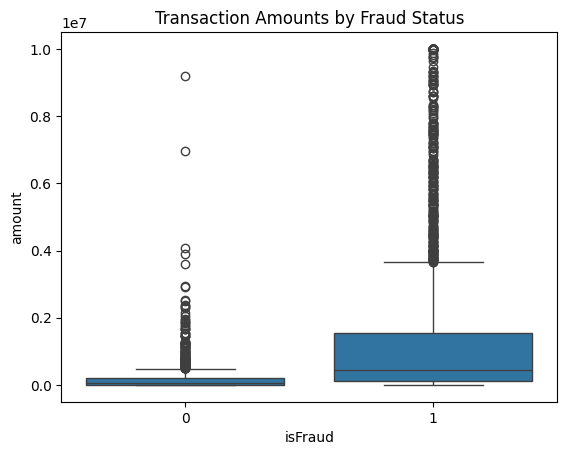

In [166]:
# Distribution of transaction amounts by fraud status
sns.boxplot(x='isFraud', y='amount', data=df_synt)
plt.title('Transaction Amounts by Fraud Status')
plt.show()

#### Check for outliers

In [19]:
# Calculate Z-scores
z_scores = np.abs(stats.zscore(df_synt[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]))

# Identify outliers
outliers = (z_scores > 3)
print(np.where(outliers))

(array([   4,    4,   26,   26,   40,   40,   48,   48,   96,   96,   98,
         98,  126,  149,  149,  150,  153,  153,  159,  173,  191,  192,
        201,  222,  222,  232,  232,  252,  252,  262,  262,  266,  266,
        269,  276,  276,  287,  287,  304,  316,  316,  317,  328,  328,
        346,  346,  366,  366,  386,  386,  407,  427,  427,  440,  440,
        442,  457,  457,  460,  460,  500,  553,  553,  561,  561,  586,
        586,  598,  603,  610,  617,  684,  684,  709,  709,  735,  735,
        746,  754,  754,  773,  800,  808,  808,  826,  826,  848,  848,
        885,  885,  885,  892,  938,  938,  948,  948,  966,  967, 1013,
       1013, 1083, 1083, 1106, 1106, 1112, 1121, 1127, 1127, 1143, 1144,
       1144, 1150, 1150, 1156, 1169, 1169, 1179, 1179, 1183, 1183, 1186,
       1196, 1196, 1238, 1246, 1246, 1253, 1264, 1271, 1271, 1294, 1294,
       1297, 1297, 1312, 1312, 1314, 1314, 1346, 1352, 1357, 1357, 1357,
       1426, 1426, 1429, 1429, 1435, 1435, 1459, 1

In [21]:
# Extract outliers
row_indices, col_indices = np.where(z_scores > 3)

# Print the rows with outliers
outlier_rows = df_synt.iloc[row_indices]

# Print the columns where outliers are found
columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
outlier_details = pd.DataFrame({
    'Row Index': row_indices,
    'Column Index': col_indices,
    'Value': df_synt[columns].values[row_indices, col_indices]
})
outlier_details.head(10)

,Row Index,Column Index,Value
0,4,1,16504703.57
1,4,2,16525573.41
2,26,3,17051087.32
3,26,4,17208715.67
4,40,0,10000000.00
5,40,1,10000000.00
6,48,1,10723050.81
7,48,2,10957343.84
8,96,3,22160714.25
9,96,4,24231654.14


(76, 4): In the 77th row, the outlier is in the 5th column.
(79, 4): In the 80th row, the outlier is in the 5th column.
(80, 4): In the 81st row, the outlier is in the 5th column,
etc.

In [22]:
# Remove outliers based on Z-score
threshold = 3
filtered_df = df_synt[(np.abs(stats.zscore(df_synt[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])) < threshold).all(axis=1)]

##### Count of flagged frauds

In [23]:
flagged_fraud_counts = filtered_df[filtered_df['isFlaggedFraud'] == 1].groupby('type').size()
print(flagged_fraud_counts)

# Compare flagged frauds with actual frauds
actual_vs_flagged = filtered_df.groupby(['type', 'isFraud', 'isFlaggedFraud']).size().unstack(fill_value=0)
print(actual_vs_flagged)

Series([], dtype: int64)
isFlaggedFraud       0
type     isFraud      
CASH_IN  0         499
CASH_OUT 0         924
         1        2604
DEBIT    0          18
PAYMENT  0        1036
TRANSFER 0         216
         1           5


#### Correlation Matrix

In [24]:
# Selecting the columns of numerical type
numeric_columns = filtered_df.select_dtypes(include=['int', 'float']).columns
numeric_data = filtered_df[numeric_columns]

# pearson corrleation matrix of the numerical data
correlation = numeric_data.corr()

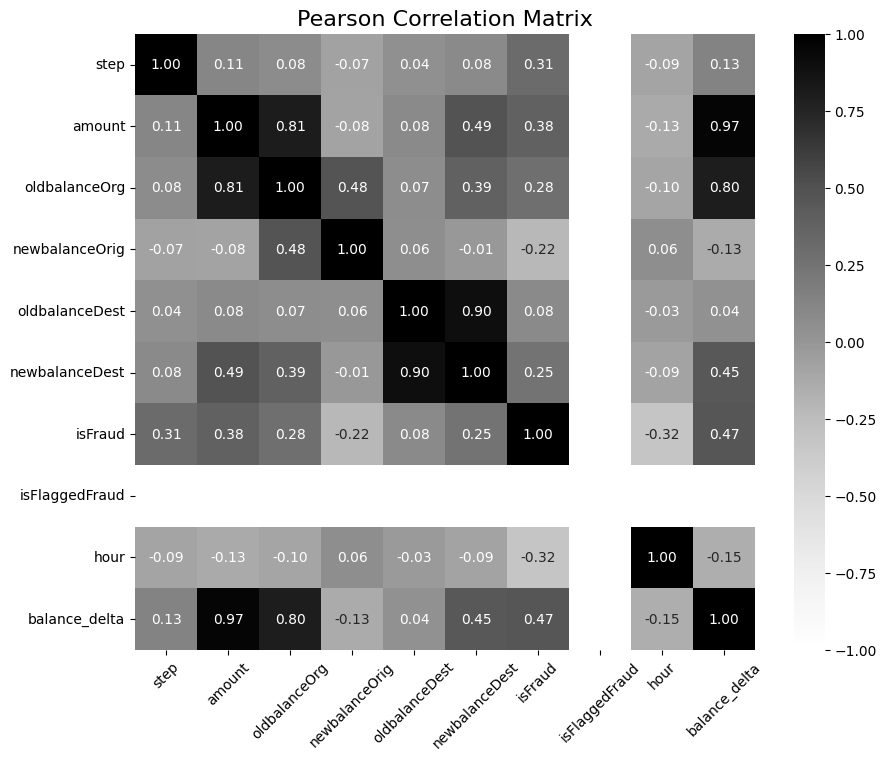

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation,vmin = -1, cmap = "Greys", vmax = 1,annot = True, fmt = '.2f')
plt.title('Pearson Correlation Matrix', fontsize=16)
plt.xticks(rotation = 45)
plt.show()

#### Distribution of transactions across different hours of the day

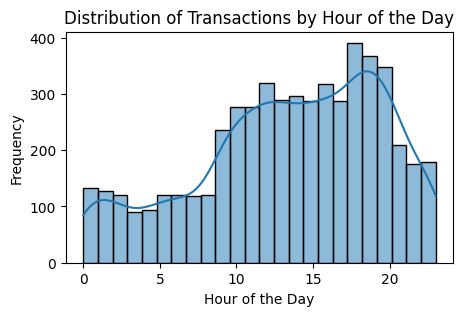

In [26]:
# Hour of the Day
plt.figure(figsize=(5, 3))
sns.histplot(filtered_df['hour'], bins=24, kde=True)
plt.title('Distribution of Transactions by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.show()

Between 0 and 9 there weren't that many transactions. 
There were high peak transactions in the hour of 18 and 20.


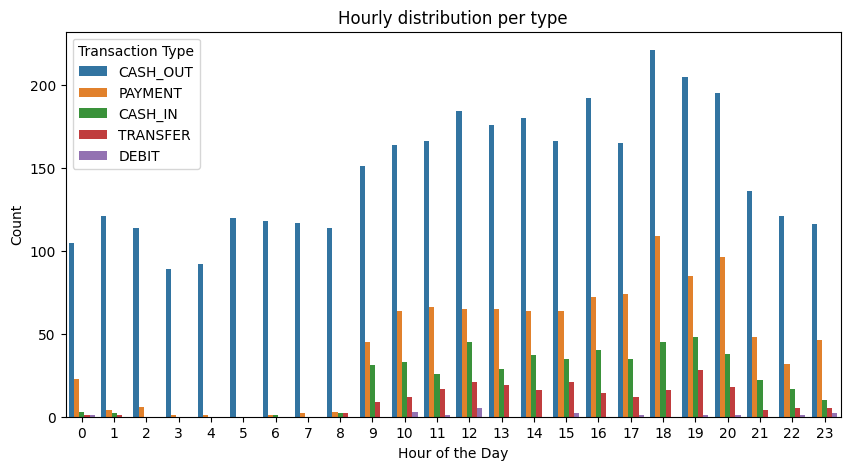

In [27]:
# Plotting the counts of each transaction type
plt.figure(figsize=(10, 5))
sns.countplot(data=filtered_df, x='hour', hue='type')
plt.title('Hourly distribution per type')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.legend(title='Transaction Type')
plt.show()

Peaks in transaction volume during certain hours may indicate periods of increased activity, which could be due to various factors such as end-of-day processing, scheduled batch transfers, or specific business operations.

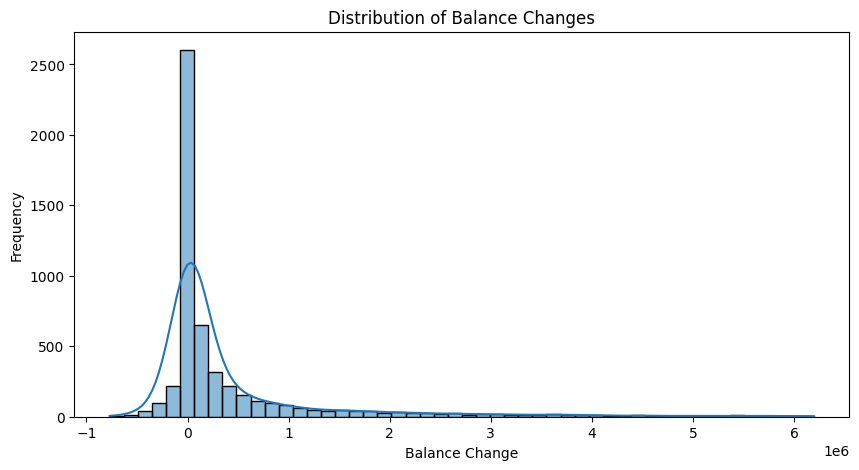

In [201]:
# Balance Change
plt.figure(figsize=(10, 5))
sns.histplot(filtered_df['balance_delta'], bins=50, kde=True)
plt.title('Distribution of Balance Changes')
plt.xlabel('Balance Change')
plt.ylabel('Frequency')
plt.show()

Plot line charts to analyze hourly trends in transaction volume or fraud rates. This can help identify recurring patterns or anomalies over time.

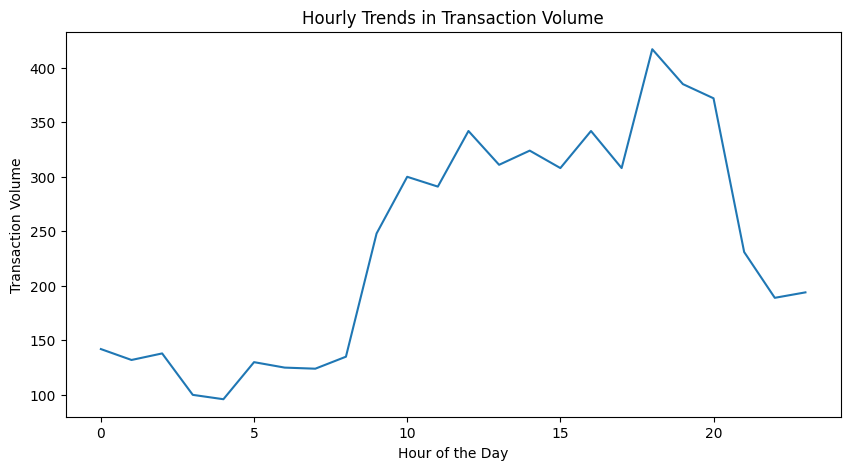

In [86]:
# Hourly Trends
hourly_transactions = df_synt.groupby('hour').size()
plt.figure(figsize=(10, 5))
hourly_transactions.plot(kind='line')
plt.title('Hourly Trends in Transaction Volume')
plt.xlabel('Hour of the Day')
plt.ylabel('Transaction Volume')
plt.show()

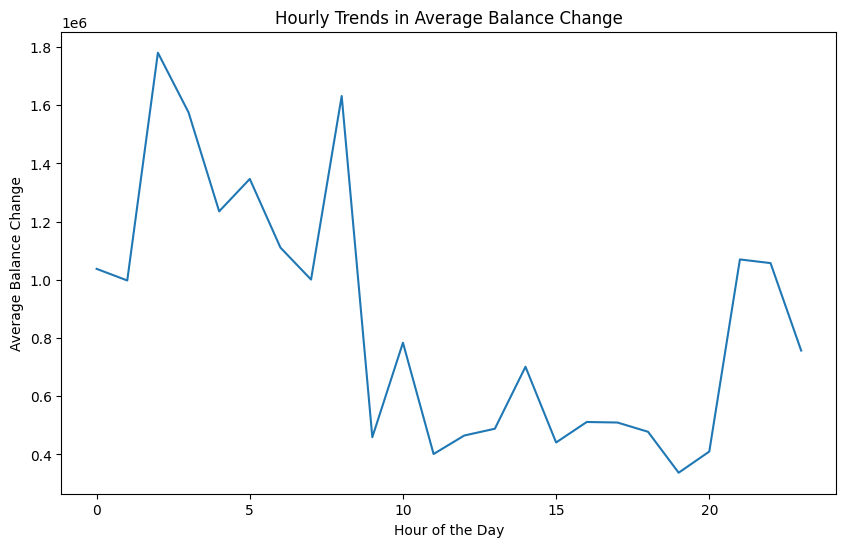

In [87]:
# Balance Evolution
plt.figure(figsize=(10, 6))
df_synt.groupby('hour')['balance_delta'].mean().plot(kind='line')
plt.title('Hourly Trends in Average Balance Change')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Balance Change')
plt.show()

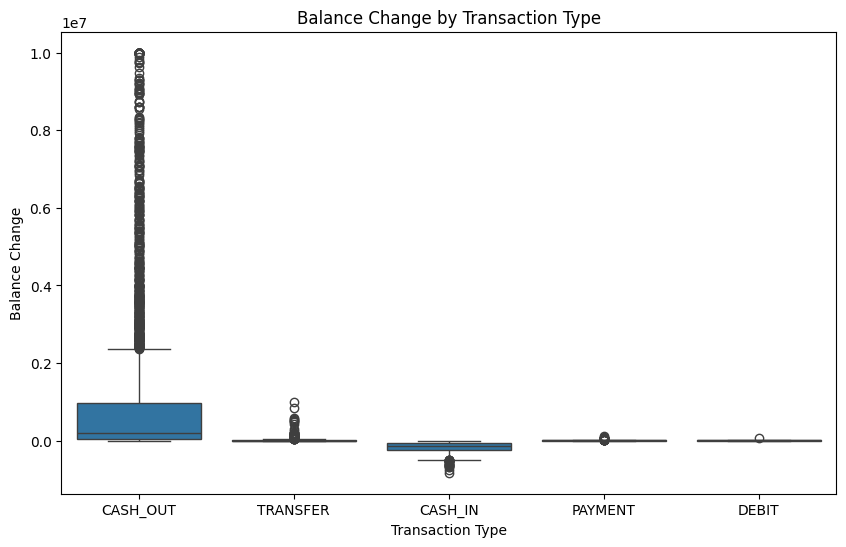

In [88]:
# Transaction Type vs. Balance Change
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_synt, x='type', y='balance_delta')
plt.title('Balance Change by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Balance Change')
plt.show()

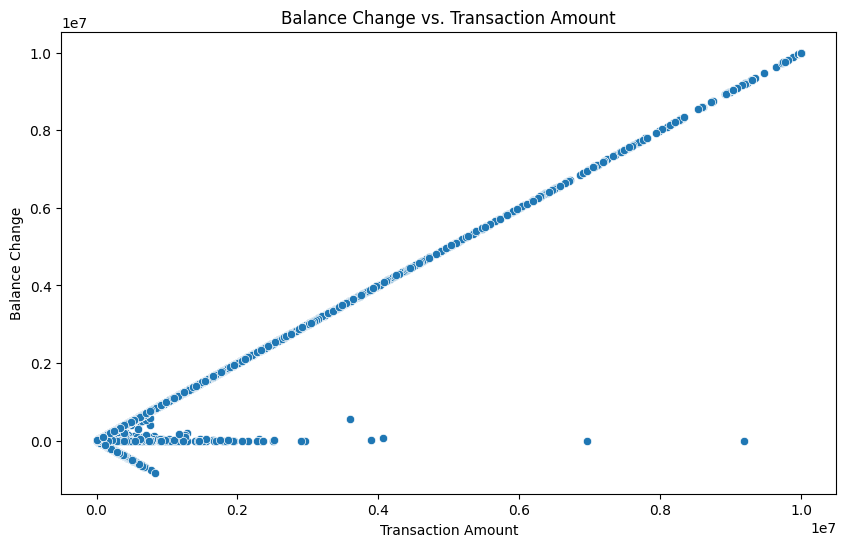

In [89]:
# Balance Change vs. Transaction Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_synt, x='amount', y='balance_delta')
plt.title('Balance Change vs. Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Balance Change')
plt.show()

Lines from 0 on the X-axis to 1.0 on the Y-axis and 0 to -0.2 on the Y-axis:

    These lines suggest a strong relationship or correlation between transaction amount and balance change for certain subsets of transactions.
    The line extending from 0 on the X-axis to 1.0 on the Y-axis indicates transactions where the entire transaction amount is reflected as a balance change of 1.0. This could be due to transactions such as deposits or transfers where the full transaction amount is added to the account balance.
    The line extending from 0 on the X-axis to -0.2 on the Y-axis suggests transactions where a portion of the transaction amount results in a balance decrease of approximately 0.2. This could be indicative of fees, charges, or deductions associated with the transaction.



#### Flag large transactions

In [28]:
filtered_df["amount"].mean()

517047.0744473784

In [29]:
filtered_df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,balance_delta,large_transaction
5689,400,CASH_IN,120724.07,C181463151,2795035.17,2915759.25,C1087971219,491909.92,371185.85,0,0,16,-120724.08,False
5690,210,CASH_OUT,1651948.79,C620061851,1651948.79,0.00,C2027305052,1014365.76,2666314.55,1,0,18,1651948.79,True
5691,76,CASH_OUT,9917.27,C1776957208,9917.27,0.00,C776312807,408610.64,418527.91,1,0,4,9917.27,False
5692,396,PAYMENT,2986.01,C596951620,100235.00,97248.99,M1602941695,0.00,0.00,0,0,12,2986.01,False
5693,205,CASH_OUT,96640.12,C1384674068,96640.12,0.00,C505855307,1569508.75,1666148.87,1,0,13,96640.12,False


### Clustering

In [30]:
# Select numerical features for clustering
numerical_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

In [31]:
# Extract numerical data
X = filtered_df[numerical_features]

In [32]:
# Split the dataset into training and test sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [33]:
# Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
# Choose the number of clusters (you may need to experiment with this)
n_clusters = 3

# Initialise KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit KMeans to the scaled data
# kmeans.fit(X_scaled)
# Fit KMeans to the scaled training data
kmeans.fit(X_train_scaled)

# Predict cluster labels for both training and test sets
train_cluster_labels = kmeans.labels_
test_cluster_labels = kmeans.predict(X_test_scaled)

#### Cluster profiling
> To give insights into the typical behavior of transactions within each cluster.

In [35]:
# Calculate cluster centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Create a DataFrame to store cluster centers
cluster_centers_df = pd.DataFrame(cluster_centers, columns=numerical_features)

# Display cluster centers
print("Cluster Centers:")
print(cluster_centers_df)

Cluster Centers:
         amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest
0  6.211435e+05   4.989845e+05    1.003102e+05    6.538357e+06    7.185851e+06
1  2.615598e+05   2.368133e+05    5.350819e+04    5.477720e+05    7.910684e+05
2  2.501799e+06   3.417632e+06    1.009486e+06    1.069028e+06    3.484626e+06


#### Feature importance
> calculates the feature importance based on the absolute values of cluster centers in KMeans, providing insights into which features contribute most to cluster separation.

In [ ]:
# Extract feature importances from KMeans
if hasattr(kmeans, 'cluster_centers_'):
    cluster_centers_abs = np.abs(cluster_centers)
    total_importance = cluster_centers_abs.sum(axis=1)
    feature_importance = total_importance / total_importance.sum()
    feature_importance_df = pd.DataFrame({'Feature': numerical_features, 'Importance': feature_importance})
    print("Feature Importance:")
    print(feature_importance_df)
    
# # Ensure numerical_features and feature_importance have the same length
# if len(numerical_features) != len(feature_importance):
#     numerical_features = numerical_features[:len(feature_importance)]

# # Create feature_importance_df with adjusted arrays
# feature_importance_df = pd.DataFrame({'Feature': numerical_features, 'Importance': feature_importance})

In [212]:
feature_importance_df

,Feature,Importance
0,amount,0.024181
1,oldbalanceOrg,0.166271
2,newbalanceOrig,0.650002
3,oldbalanceDest,0.159546


The feature importance analysis suggests that 'oldbalanceDest' contributes the most to cluster separation, followed by 'newbalanceOrig'. 'Amount' contributes the least to cluster separation.

#### Dimensionality Reduction (PCA)

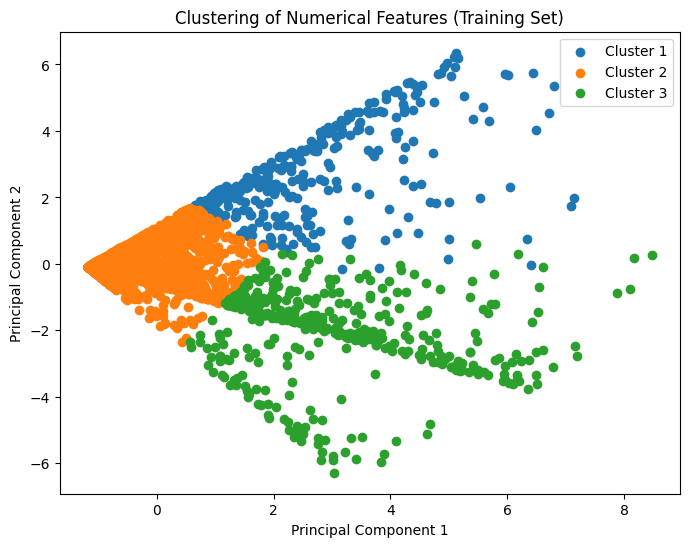

In [39]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Plot clusters for the training set
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(X_train_pca[train_cluster_labels == i, 0], X_train_pca[train_cluster_labels == i, 1], label=f'Cluster {i+1}')
plt.title('Clustering of Numerical Features (Training Set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [40]:
# Create a DataFrame to store PCA results for the training set
train_pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
train_pca_df['Cluster'] = train_cluster_labels

#### Anomaly Detection Within Clusters
> After identifying the clusters, apply anomaly detection techniques within each cluster to identify any unusual transactions.

In [225]:
# Anomaly detection with Isolation Forest on the training set

# store whether each data point is an anomaly (1) or not (0)
anomaly_labels_train = np.zeros(len(X_train_scaled), dtype=int)
anomaly_scores_train = np.zeros(len(X_train_scaled))

for cluster_label in range(n_clusters):
    cluster_indices = np.where(train_cluster_labels == cluster_label)[0]
    X_cluster = X_train_scaled[cluster_indices]
    
    isolation_forest = IsolationForest(contamination='auto', random_state=42)
    isolation_forest.fit(X_cluster)
    
    scores = isolation_forest.decision_function(X_cluster)
    anomalies = isolation_forest.predict(X_cluster) == -1
    
    anomaly_labels_train[cluster_indices] = anomalies
    anomaly_scores_train[cluster_indices] = scores

# Print the number of anomalies detected in each cluster
for cluster_label in range(n_clusters):
    num_anomalies = np.sum(anomaly_labels_train[train_cluster_labels == cluster_label])
    print(f"Cluster {cluster_label}: {num_anomalies} anomalies")

# Apply anomaly detection on the test set
anomaly_labels_test = np.zeros(len(X_test_scaled), dtype=int)
anomaly_scores_test = np.zeros(len(X_test_scaled))

for cluster_label in range(n_clusters):
    cluster_indices = np.where(test_cluster_labels == cluster_label)[0]  # Assuming test_cluster_labels is defined
    X_cluster_test = X_test_scaled[cluster_indices]
    
    isolation_forest = IsolationForest(contamination='auto', random_state=42)
    isolation_forest.fit(X_cluster_test)
    
    scores_test = isolation_forest.decision_function(X_cluster_test)
    anomalies_test = isolation_forest.predict(X_cluster_test) == -1
    
    anomaly_labels_test[cluster_indices] = anomalies_test
    anomaly_scores_test[cluster_indices] = scores_test

# Concatenate the anomaly labels for both train and test sets
all_anomaly_labels = np.concatenate([anomaly_labels_train, anomaly_labels_test])

# Ensure `filtered_df` can accommodate these labels and assign them using `.loc`
filtered_df = filtered_df.copy()  # Ensure it's a copy to avoid the warning
filtered_df['Anomaly'] = all_anomaly_labels

# Also, add the anomaly labels to the PCA DataFrame for training set
train_pca_df['Anomaly'] = anomaly_labels_train

# Print some summary statistics if needed
print(f"Total anomalies in training set: {np.sum(anomaly_labels_train)}")
print(f"Total anomalies in test set: {np.sum(anomaly_labels_test)}")

Cluster 0: 50 anomalies
Cluster 1: 675 anomalies
Cluster 2: 119 anomalies
Total anomalies in training set: 844
Total anomalies in test set: 221


In [226]:
filtered_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,balance_delta,large_transaction,Anomaly
0,367,CASH_OUT,972009.75,C961270274,972009.75,0.0,C1692249598,298095.31,1270105.06,1,0,7,972009.75,True,1
1,210,TRANSFER,182417.23,C1791585479,0.00,0.0,C1376183040,1002955.42,1185372.65,0,0,18,0.00,False,1
2,226,CASH_OUT,223763.08,C1537801609,0.00,0.0,C2058014912,359801.68,583564.75,0,0,10,0.00,True,0
3,261,CASH_OUT,89120.05,C1922744585,0.00,0.0,C1000322805,148643.27,237763.32,0,0,21,0.00,False,0
5,52,CASH_OUT,1093155.19,C395947070,1093155.19,0.0,C1747066716,1966451.64,3059606.83,1,0,4,1093155.19,True,0


In [42]:
# Anomaly detection with Isolation Forest on the training set
anomaly_labels_train = np.zeros(len(X_train_scaled), dtype=int)
anomaly_scores_train = np.zeros(len(X_train_scaled))

for cluster_label in range(n_clusters):
    cluster_indices = np.where(train_cluster_labels == cluster_label)[0]
    X_cluster = X_train_scaled[cluster_indices]
    
    isolation_forest = IsolationForest(contamination='auto', random_state=42)
    isolation_forest.fit(X_cluster)
    
    scores = isolation_forest.decision_function(X_cluster)
    anomalies = isolation_forest.predict(X_cluster) == -1
    
    anomaly_labels_train[cluster_indices] = anomalies
    anomaly_scores_train[cluster_indices] = scores

# Print the number of anomalies detected in each cluster
for cluster_label in range(n_clusters):
    num_anomalies = np.sum(anomaly_labels_train[train_cluster_labels == cluster_label])
    print(f"Cluster {cluster_label}: {num_anomalies} anomalies")

Cluster 0: 50 anomalies
Cluster 1: 675 anomalies
Cluster 2: 119 anomalies


In [43]:
# Anomaly detection on the test set as well
anomaly_labels_test = np.zeros(len(X_test_scaled), dtype=int)
anomaly_scores_test = np.zeros(len(X_test_scaled))

for cluster_label in range(n_clusters):
    cluster_indices = np.where(test_cluster_labels == cluster_label)[0]  
    X_cluster_test = X_test_scaled[cluster_indices]
    
    isolation_forest = IsolationForest(contamination='auto', random_state=42)
    isolation_forest.fit(X_cluster_test)
    
    scores_test = isolation_forest.decision_function(X_cluster_test)
    anomalies_test = isolation_forest.predict(X_cluster_test) == -1
    
    anomaly_labels_test[cluster_indices] = anomalies_test
    anomaly_scores_test[cluster_indices] = scores_test

# Concatenate the anomaly labels for both train and test sets
all_anomaly_labels = np.concatenate([anomaly_labels_train, anomaly_labels_test])

# Ensure `filtered_df` can accommodate these labels and assign them using `.loc`
filtered_df = filtered_df.copy()  # Ensure it's a copy to avoid the warning
filtered_df['Anomaly'] = all_anomaly_labels

# Add the 'Set' column
num_train_samples = len(X_train_scaled)
num_test_samples = len(X_test_scaled)
filtered_df['Set'] = ['train'] * num_train_samples + ['test'] * num_test_samples

# Prepare the ground truth labels
y_true_train = filtered_df[filtered_df['Set'] == 'train']['isFraud'].values
y_true_test = filtered_df[filtered_df['Set'] == 'test']['isFraud'].values

# Combine the ground truth labels and predicted anomaly labels
y_true = np.concatenate([y_true_train, y_true_test])
y_pred = np.concatenate([anomaly_labels_train, anomaly_labels_test])

In [44]:
# Calculate confusion matrix and evaluation metrics
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print the classification report
report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[2140  553]
 [2097  512]]
Accuracy: 0.5002
Precision: 0.4808
Recall: 0.1962
F1 Score: 0.2787

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.79      0.62      2693
           1       0.48      0.20      0.28      2609

    accuracy                           0.50      5302
   macro avg       0.49      0.50      0.45      5302
weighted avg       0.49      0.50      0.45      5302



The model has a high number of false negatives (2097), indicating that many true anomalies are not being detected.
The recall for class 1 (anomalies) is quite low (0.20), which means the model is missing a large portion of the actual anomalies.
The precision for both classes is moderate, but the low recall for anomalies significantly reduces the F1 score for that class.

### Autoencoders

In [45]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define an autoencoder architecture
input_dim = X_train_scaled.shape[1]  # Number of features
encoding_dim = 32  # Dimension of the encoded representation

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder on normal data
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=10, batch_size=64, shuffle=True)

# Use the trained autoencoder to reconstruct both normal and anomalous data
reconstructed = autoencoder.predict(X_train_scaled)

# Calculate reconstruction error (e.g., mean squared error)
mse = np.mean(np.square(X_train_scaled - reconstructed), axis=1)

# Set a threshold for the reconstruction error
threshold = np.mean(mse) + 2 * np.std(mse)  # Example threshold

# Identify anomalies based on the threshold
anomaly_labels_train = mse > threshold

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5747  
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0309
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.7704
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -1.7007
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -2.8677
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -4.2518
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -6.3482
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -8.7561
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -11.4544
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -14.9517
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


1. Evaluate Reconstruction Performance:

In [46]:
# Use the trained autoencoder to reconstruct both normal and anomalous data
reconstructed_train = autoencoder.predict(X_train_scaled)
reconstructed_test = autoencoder.predict(X_test_scaled)

# Calculate reconstruction error (e.g., mean squared error)
mse_train = np.mean(np.square(X_train_scaled - reconstructed_train), axis=1)
mse_test = np.mean(np.square(X_test_scaled - reconstructed_test), axis=1)

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step


2. Set Reconstruction Error Threshold:

In [47]:
# Determine threshold based on mean and standard deviation of reconstruction errors
threshold = np.mean(mse_train) + 2 * np.std(mse_train)  # Example threshold

3. Identify Anomalies:

In [48]:
# Classify data points with reconstruction errors above the threshold as anomalies
anomaly_labels_train = mse_train > threshold
anomaly_labels_test = mse_test > threshold

4. Evaluate Anomaly Detection Performance:

In [49]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Evaluate performance on the training set
y_true_train = np.concatenate([np.zeros(len(X_train_scaled)), np.ones(len(X_test_scaled))])  # Assuming no anomalies in the training set
y_pred_train = np.concatenate([anomaly_labels_train, anomaly_labels_test])

# Calculate and print evaluation metrics
conf_matrix_train = confusion_matrix(y_true_train, y_pred_train)
accuracy_train = accuracy_score(y_true_train, y_pred_train)
precision_train = precision_score(y_true_train, y_pred_train)
recall_train = recall_score(y_true_train, y_pred_train)
f1_train = f1_score(y_true_train, y_pred_train)

print("Training Set Evaluation:")
print("Confusion Matrix:")
print(conf_matrix_train)
print(f"Accuracy: {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1 Score: {f1_train:.4f}")

Training Set Evaluation:
Confusion Matrix:
[[4058  183]
 [1020   41]]
Accuracy: 0.7731
Precision: 0.1830
Recall: 0.0386
F1 Score: 0.0638


In [75]:
# Print the classification report
report = classification_report(y_true_train, y_pred_train)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.96      0.87      4241
         1.0       0.18      0.04      0.06      1061

    accuracy                           0.77      5302
   macro avg       0.49      0.50      0.47      5302
weighted avg       0.68      0.77      0.71      5302



### LSTM Model

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [51]:
filtered_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,balance_delta,large_transaction,Anomaly,Set
0,367,CASH_OUT,972009.75,C961270274,972009.75,0.0,C1692249598,298095.31,1270105.06,1,0,7,972009.75,True,1,train
1,210,TRANSFER,182417.23,C1791585479,0.00,0.0,C1376183040,1002955.42,1185372.65,0,0,18,0.00,False,1,train
2,226,CASH_OUT,223763.08,C1537801609,0.00,0.0,C2058014912,359801.68,583564.75,0,0,10,0.00,True,0,train
3,261,CASH_OUT,89120.05,C1922744585,0.00,0.0,C1000322805,148643.27,237763.32,0,0,21,0.00,False,0,train
5,52,CASH_OUT,1093155.19,C395947070,1093155.19,0.0,C1747066716,1966451.64,3059606.83,1,0,4,1093155.19,True,0,train


In [52]:
df_encoded = pd.get_dummies(filtered_df, columns=['type'])

In [53]:
# Split dataset into train and test sets (80% train, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(df_encoded.drop(columns=['isFraud', 'Set']), df_encoded['isFraud'], test_size=0.2, random_state=42)

# Split train and validation sets (60% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

In [54]:
# Print sizes of train, validation, and test sets
print("Train set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Train set size: 3180
Validation set size: 1061
Test set size: 1061


In [57]:
model_lstm = Sequential([
    LSTM(units=50, activation='relu', input_shape=(n_steps, n_features)),
    Dense(1)
])

c:\Users\deyna\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:
# Compile LSTM model
model_lstm.compile(optimizer='adam', loss='mse')

In [66]:
# Reshape input data for LSTM model
X_train_reshaped = X_train.values.reshape(-1, n_steps, n_features)
X_val_reshaped = X_val.values.reshape(-1, n_steps, n_features)
X_test_reshaped = X_test.values.reshape(-1, n_steps, n_features)

ValueError: cannot reshape array of size 57240 into shape (1,16)

In [62]:
X_train_numeric = X_train.select_dtypes(exclude=['object'])
X_val_numeric = X_val.select_dtypes(exclude=['object'])
X_test_numeric = X_test.select_dtypes(exclude=['object'])

In [65]:
# Define the variables
n_steps = 1
n_features = X_train_numeric.shape[1]
epochs = 10
batch_size = 32

In [271]:
# Convert input data to float32
X_train_reshaped = X_train_numeric.values.reshape(-1, n_steps, n_features)
X_val_reshaped = X_val_numeric.values.reshape(-1, n_steps, n_features)
X_test_reshaped = X_test_numeric.values.reshape(-1, n_steps, n_features)

X_train_reshaped = X_train_reshaped.astype(np.float32)
X_val_reshaped = X_val_reshaped.astype(np.float32)
X_test_reshaped = X_test_reshaped.astype(np.float32)

In [272]:
# Check target variable data types
print("Train target variable data type:", y_train.dtype)
print("Validation target variable data type:", y_val.dtype)
print("Test target variable data type:", y_test.dtype)

# Check input data types
print("Train input data type:", X_train_reshaped.dtype)
print("Validation input data type:", X_val_reshaped.dtype)
print("Test input data type:", X_test_reshaped.dtype)

# Print input shape
print("Train input shape:", X_train_reshaped.shape)
print("Validation input shape:", X_val_reshaped.shape)
print("Test input shape:", X_test_reshaped.shape)

# Print unique values in target variable
print("Unique values in train target variable:", np.unique(y_train))
print("Unique values in validation target variable:", np.unique(y_val))
print("Unique values in test target variable:", np.unique(y_test))


Train target variable data type: float32
Validation target variable data type: float32
Test target variable data type: float32
Train input data type: float32
Validation input data type: float32
Test input data type: float32
Train input shape: (3180, 1, 16)
Validation input shape: (1061, 1, 16)
Test input shape: (1061, 1, 16)
Unique values in train target variable: [0. 1.]
Unique values in validation target variable: [0. 1.]
Unique values in test target variable: [0. 1.]


In [ ]:
# Train LSTM model
history = model_lstm.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_reshaped, y_val))

In [ ]:
# Evaluate LSTM model
loss = model_lstm.evaluate(X_test_reshaped, y_test)

In [ ]:
# Predictions
y_pred_lstm = model_lstm.predict(X_test_reshaped)

In [ ]:
# Calculate prediction errors
errors_lstm = np.abs(y_test - y_pred_lstm.flatten())

In [ ]:
# Calculate anomalies based on prediction errors
threshold_lstm = 0.5  # Example threshold
anomalies_lstm = errors_lstm > threshold_lstm

In [ ]:
print("Evaluation Loss:", loss)

### SVM

In [67]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [68]:
# Remove non-numeric columns for SVM
numeric_cols = filtered_df.select_dtypes(include=[np.number]).columns
filtered_df_numeric = filtered_df[numeric_cols]

In [70]:
filtered_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,balance_delta,large_transaction,Anomaly,Set
0,367,CASH_OUT,972009.75,C961270274,972009.75,0.00,C1692249598,298095.31,1270105.06,1,0,7,972009.75,True,1,train
1,210,TRANSFER,182417.23,C1791585479,0.00,0.00,C1376183040,1002955.42,1185372.65,0,0,18,0.00,False,1,train
2,226,CASH_OUT,223763.08,C1537801609,0.00,0.00,C2058014912,359801.68,583564.75,0,0,10,0.00,True,0,train
3,261,CASH_OUT,89120.05,C1922744585,0.00,0.00,C1000322805,148643.27,237763.32,0,0,21,0.00,False,0,train
5,52,CASH_OUT,1093155.19,C395947070,1093155.19,0.00,C1747066716,1966451.64,3059606.83,1,0,4,1093155.19,True,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5689,400,CASH_IN,120724.07,C181463151,2795035.17,2915759.25,C1087971219,491909.92,371185.85,0,0,16,-120724.08,False,1,test
5690,210,CASH_OUT,1651948.79,C620061851,1651948.79,0.00,C2027305052,1014365.76,2666314.55,1,0,18,1651948.79,True,0,test
5691,76,CASH_OUT,9917.27,C1776957208,9917.27,0.00,C776312807,408610.64,418527.91,1,0,4,9917.27,False,0,test
5692,396,PAYMENT,2986.01,C596951620,100235.00,97248.99,M1602941695,0.00,0.00,0,0,12,2986.01,False,0,test


In [71]:
target_columns = ['isFraud', 'Anomaly']
if 'Set' in filtered_df_numeric.columns:
    target_columns.append('Set')

feature_cols = filtered_df_numeric.columns.drop(target_columns)

# Split the dataset into train and test sets (80% train, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(filtered_df_numeric[feature_cols], filtered_df_numeric['isFraud'], test_size=0.2, random_state=42)

# Split train and validation sets (60% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

In [72]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train the OneClassSVM model
svm_model = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')
svm_model.fit(X_train_scaled)

# Predict anomalies on the validation and test sets
y_val_pred = svm_model.predict(X_val_scaled)
y_test_pred = svm_model.predict(X_test_scaled)

# Convert predictions from {-1, 1} to {0, 1} where -1 is anomaly
y_val_pred = np.where(y_val_pred == -1, 1, 0)
y_test_pred = np.where(y_test_pred == -1, 1, 0)

In [73]:
# Evaluate the model on the validation set
print("Validation Set Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred))
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Set Evaluation:
Confusion Matrix:
[[516  27]
 [485  33]]
Accuracy: 0.5174363807728558
Precision: 0.55
Recall: 0.0637065637065637
F1 Score: 0.11418685121107267
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.95      0.67       543
           1       0.55      0.06      0.11       518

    accuracy                           0.52      1061
   macro avg       0.53      0.51      0.39      1061
weighted avg       0.53      0.52      0.40      1061



In [74]:
# Evaluate the model on the test set
print("Test Set Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Test Set Evaluation:
Confusion Matrix:
[[533  15]
 [477  36]]
Accuracy: 0.5362865221489161
Precision: 0.7058823529411765
Recall: 0.07017543859649122
F1 Score: 0.1276595744680851
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.97      0.68       548
           1       0.71      0.07      0.13       513

    accuracy                           0.54      1061
   macro avg       0.62      0.52      0.41      1061
weighted avg       0.61      0.54      0.42      1061



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Assuming y_true contains the ground truth labels for anomalies (1 for anomaly, 0 for normal)
# and anomaly_labels contains the predicted labels from the Isolation Forest

# Calculate precision
precision = precision_score(y_true, anomaly_labels)

# Calculate recall
recall = recall_score(y_true, anomaly_labels)

# Calculate F1-score
f1 = f1_score(y_true, anomaly_labels)

# Calculate ROC AUC score
# For ROC AUC, you need the decision scores rather than binary labels
roc_auc = roc_auc_score(y_true, anomaly_scores)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

In [219]:
# Analyze anomalies in the original DataFrame
anomalies = filtered_df[filtered_df['Anomaly'] == 1]
anomalies.describe().T

,count,mean,std,min,25%,50%,75%,max
step,844.0,3.014467e+02,1.967040e+02,1.00,156.0000,282.000,4.100000e+02,741.00
amount,844.0,5.454323e+05,9.963293e+05,137.35,34852.1250,173266.595,4.979925e+05,6029387.26
oldbalanceOrg,844.0,5.831711e+05,1.154609e+06,0.00,2183.5000,82038.390,5.009546e+05,6075446.31
newbalanceOrig,844.0,1.422981e+05,6.841195e+05,0.00,0.0000,0.000,0.000000e+00,6224022.83
oldbalanceDest,844.0,1.063753e+06,1.965604e+06,0.00,21790.7825,279146.700,1.006342e+06,13565723.37
newbalanceDest,844.0,1.591558e+06,2.303988e+06,0.00,90206.7675,642263.255,2.100829e+06,13437748.68
isFraud,844.0,4.893365e-01,5.001827e-01,0.00,0.0000,0.000,1.000000e+00,1.00
isFlaggedFraud,844.0,0.000000e+00,0.000000e+00,0.00,0.0000,0.000,0.000000e+00,0.00
hour,844.0,1.350355e+01,6.170279e+00,0.00,10.0000,15.000,1.900000e+01,23.00
balance_delta,844.0,4.408730e+05,1.018516e+06,-771010.78,0.0000,24359.040,3.538136e+05,6029387.26


In [222]:
# Predict anomalies in the test set
test_scores = isolation_forest.decision_function(X_test_scaled)
test_anomalies = isolation_forest.predict(X_test_scaled) == -1

# Analyze test anomalies
print(np.sum(test_anomalies))

971


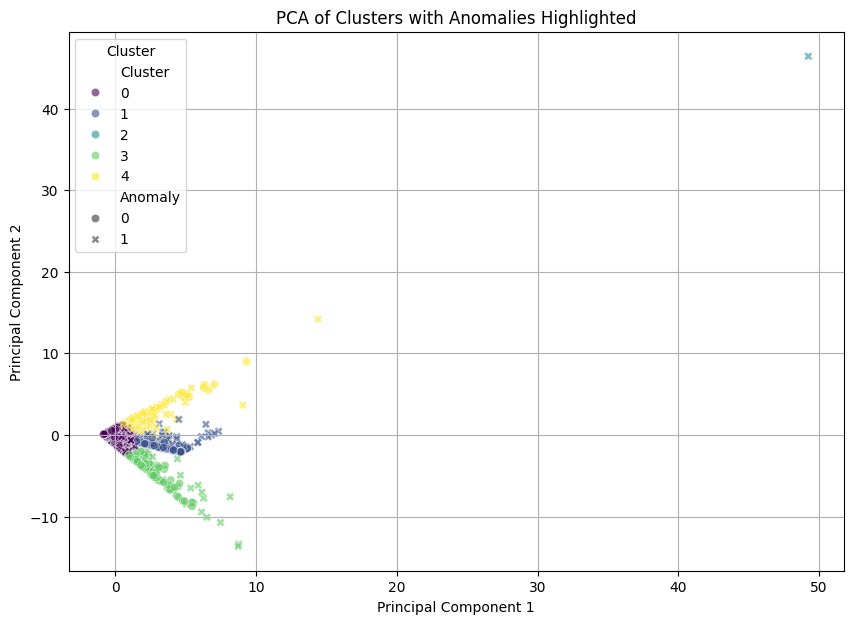

In [116]:
# Plot PCA with anomalies highlighted
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Cluster', palette='viridis', data=train_pca_df, alpha=0.6, style=train_pca_df['Anomaly'], markers={0: 'o', 1: 'X'})
plt.title('PCA of Clusters with Anomalies Highlighted')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [ ]:
# # Select features for anomaly detection
# features = ['step', 'amount', 'isFlaggedFraud', 'balance_diff_orig', 'balance_diff_dest', 'large_transaction']

# # Split data into training and testing sets
# X_train, X_test = train_test_split(df_synt[features], test_size=0.2, random_state=42)

In [ ]:
# # Predict anomalies on testing data
# y_pred = isolation_forest.predict(X_test)

# # Convert predictions to binary labels (1 for normal, -1 for anomaly)
# y_pred_binary = [1 if pred == 1 else -1 for pred in y_pred]

# # Calculate number of anomalies detected
# num_anomalies = sum(1 for pred in y_pred_binary if pred == -1)
# total_samples = len(X_test)
# anomaly_percentage = num_anomalies / total_samples * 100

# print(f"Number of anomalies detected: {num_anomalies}/{total_samples} ({anomaly_percentage:.2f}%)")

#### Evaluate

In [27]:
# Evaluate clustering performance using silhouette score
# silhouette_avg = silhouette_score(X_scaled, cluster_labels)
# print(f"Silhouette Score: {silhouette_avg}")

In [120]:
true_labels = df_synt['isFraud']
predicted_labels = df_synt['Anomaly']

# Calculate precision
precision = precision_score(true_labels, predicted_labels)

# Calculate recall
recall = recall_score(true_labels, predicted_labels)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)

precision_rounded = round(precision, 4)
recall_rounded = round(recall, 4)
f1_rounded = round(f1, 4)

print(f"Precision: {precision_rounded}")
print(f"Recall: {recall_rounded}")
print(f"F1 Score: {f1_rounded}")


Precision: 0.5251
Recall: 0.1325
F1 Score: 0.2117


- Precision: The precision is extremely low at approximately 0.0003, which means that out of all the instances predicted as anomalies, almost none of them are actual fraud cases.
- Recall: The recall is slightly better at approximately 0.083, indicating that the model is able to identify about 8.3% of the actual fraud cases.
- F1 Score: The F1 score, which is the harmonic mean of precision and recall, is very low as well, indicating a poor balance between precision and recall.

In [ ]:
# Apply label encoding for high cardinality columns
label_encoder = LabelEncoder()
for col in ['nameOrig', 'nameDest']:
    df_synt[col] = label_encoder.fit_transform(df_synt[col])

In [122]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer

# # List all column names except 'isFraud' which is the target column
# features = [col for col in df_synt.columns if col != 'isFraud']

# # Ensure these features exist in your dataframe
# print("Features used for training:", features)
# print("All columns in the dataframe:", df_synt.columns)

# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_samples': ['auto', 0.5, 0.75],
#     'contamination': [0.1, 0.2, 0.3],
#     'max_features': [1.0, 0.5, 0.75]
# }

# # Create a custom scorer using F1 score
# f1_scorer = make_scorer(f1_score, pos_label=1)

# # Initialise the Isolation Forest
# isolation_forest = IsolationForest(random_state=42)

# # Perform grid search
# grid_search = GridSearchCV(estimator=isolation_forest, param_grid=param_grid, scoring=f1_scorer, cv=3)
# grid_search.fit(df_synt[features], df_synt['isFraud'])

# # Get the best estimator
# best_isolation_forest = grid_search.best_estimator_

# # Predict using the best estimator
# df_synt['Anomaly'] = best_isolation_forest.predict(df_synt[features])
# df_synt['Anomaly'] = df_synt['Anomaly'].apply(lambda x: 1 if x == -1 else 0)

# # Calculate the metrics
# precision = precision_score(df_synt['isFraud'], df_synt['Anomaly'])
# recall = recall_score(df_synt['isFraud'], df_synt['Anomaly'])
# f1 = f1_score(df_synt['isFraud'], df_synt['Anomaly'])

# # Print the results
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")

In [123]:
non_numerical_columns = df_synt.select_dtypes(include=['object']).columns
print("Non-numerical columns:", non_numerical_columns)

Non-numerical columns: Index(['type'], dtype='object')


In [124]:
cardinality = df_synt[non_numerical_columns].nunique()
print("Cardinality of non-numerical columns:", cardinality)

Cardinality of non-numerical columns: type    5
dtype: int64


In [81]:
# Apply label encoding for high cardinality columns
label_encoder = LabelEncoder()
for col in ['nameOrig', 'nameDest']:
    df_synt[col] = label_encoder.fit_transform(df_synt[col])

# Investigate the transactions during the peak hour
peak_hour = hourly_transactions['hour'].idxmax()
peak_hour_transactions = hourly_transactions[hourly_transactions['hour'] == peak_hour]
print("Peak Hour Transactions:")
print(peak_hour_transactions.head())

Peak Hour Transactions:
Empty DataFrame
Columns: [step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud, hour, balance_delta, large_transaction, Anomaly]
Index: []


In [82]:
# Plot PCA with anomalies highlighted
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Cluster', palette='viridis', data=pca_df, alpha=0.6, style=pca_df['Anomaly'], markers={0: 'o', 1: 'X'})
plt.title('PCA of Clusters with Anomalies Highlighted')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [125]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# ROC-AUC Score
roc_auc = roc_auc_score(true_labels, predicted_labels)
print("ROC-AUC Score:", roc_auc)

# Classification Report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Confusion Matrix:
[[2507  340]
 [2461  376]]
ROC-AUC Score: 0.5065552061244984
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.88      0.64      2847
           1       0.53      0.13      0.21      2837

    accuracy                           0.51      5684
   macro avg       0.51      0.51      0.43      5684
weighted avg       0.51      0.51      0.43      5684



True Negatives (TN): 5,204,346
False Positives (FP): 755,290
False Negatives (FN): 2,610
True Positives (TP): 237

ROC-AUC (Receiver Operating Characteristic - Area Under Curve) is a metric that evaluates the performance of a binary classification model.
It measures the ability of the model to distinguish between the positive and negative classes.
A score of 0.478 suggests that the model's ability to discriminate between positive and negative classes is poor, as the score is close to random guessing.

The classification report provides precision, recall, F1-score, and support for each class (0 and 1).
Precision: The proportion of true positive predictions among all positive predictions made by the model.
Recall: The proportion of true positive predictions among all actual positive instances in the data.
F1-score: The harmonic mean of precision and recall, providing a balance between the two metrics.

For class 0 (negative class): High precision (1.00) and recall (0.87), indicating that the model performs well in identifying true negatives.
For class 1 (positive class): Very low precision (0.00) and recall (0.08), indicating poor performance in identifying true positives.

In [126]:
# Check if any test data is being used in the training process
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (4547, 5)
Testing Data Shape: (1137, 5)


In [44]:
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_samples': ['auto', 0.5, 0.75],
#     'contamination': [0.1, 0.2, 0.3],
#     'max_features': [1.0, 0.5, 0.75]
# }

In [45]:
# from sklearn.model_selection import GridSearchCV

# grid_search = GridSearchCV(estimator=isolation_forest, param_grid=param_grid, scoring='f1', cv=3)

In [46]:
# grid_search.fit(X_train, y_train)

In [136]:
from sklearn.model_selection import train_test_split

# Assuming 'features' contains your feature columns and 'target' contains your target column
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Assuming 'target' contains your target column
y_train = df_synt.loc[X_train.index]['isFraud']
y_test = df_synt.loc[X_test.index]['isFraud']

In [137]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the Random Forest Classifier
rf_classifier = RandomForestClassifier()

# Fit the classifier to your training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
predictions = rf_classifier.predict(X_test)

print(classification_report(y_test, rf_classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       571
           1       0.98      1.00      0.99       566

    accuracy                           0.99      1137
   macro avg       0.99      0.99      0.99      1137
weighted avg       0.99      0.99      0.99      1137



In [147]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

# Split the data into train and test sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Perform isolation forest anomaly detection on the train set
clf = IsolationForest(random_state=42)
clf.fit(X_train)

# Predict anomalies on the test set
y_pred = clf.predict(X_test)

# # Print the predicted anomalies
# print("Predicted anomalies:")
# print(y_pred)

# Anomaly scores for the training data
train_scores = clf.decision_function(X_train)
print(train_scores)

# Anomaly scores for the test data
test_scores = clf.decision_function(X_test)
print(test_scores)

[-0.14064334 -0.01419493 -0.10674765 ...  0.12479266  0.06533804
  0.1645817 ]
[0.15875885 0.14759681 0.13033633 ... 0.16886738 0.15865389 0.15395603]


In [ ]:
from sklearn.ensemble import IsolationForest

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Create an instance of the Isolation Forest model
model = IsolationForest(contamination=0.05)  # Set the contamination parameter

# Fit the model to your data
model.fit(X_train)

# Predict the anomalies in the training data
train_pred = model.predict(X_train)

# Predict the anomalies in the test data
test_pred = model.predict(X_test)

# Anomaly scores for the training data
train_scores = model.decision_function(X_train)

# Anomaly scores for the test data
test_scores = model.decision_function(X_test)


#### Further analysis

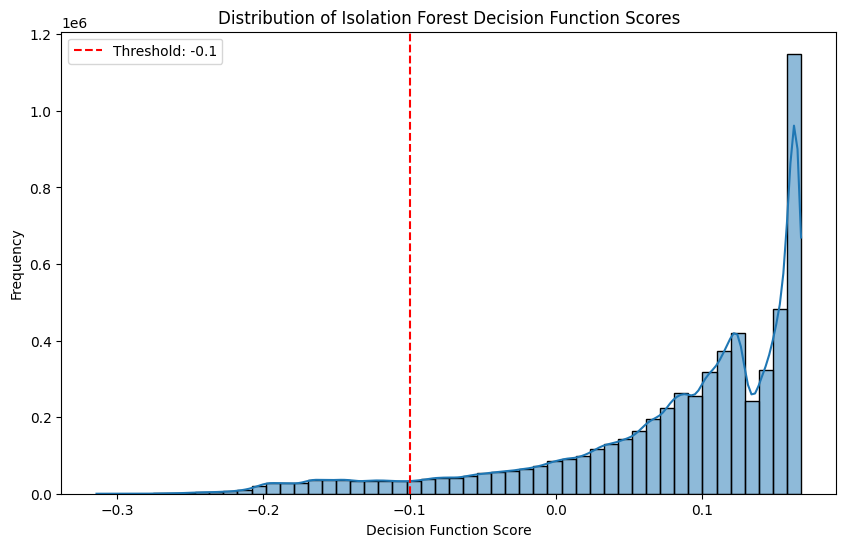

In [49]:
# Analyse anomaly scores
plt.figure(figsize=(10, 6))
sns.histplot(anomaly_scores, bins=50, kde=True)
plt.axvline(x=-0.1, color='red', linestyle='--', label='Threshold: -0.1')
plt.title('Distribution of Isolation Forest Decision Function Scores')
plt.xlabel('Decision Function Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [50]:
# Test different thresholds
thresholds = [-0.5, -0.3, -0.1, 0, 0.1]
for threshold in thresholds:
    anomaly_counts = np.sum(anomaly_scores < threshold)
    print(f"Threshold: {threshold}")
    print(f"Anomalies: {anomaly_counts}")
    print()

Threshold: -0.5
Anomalies: 0

Threshold: -0.3
Anomalies: 22

Threshold: -0.1
Anomalies: 383127

Threshold: 0
Anomalies: 937653

Threshold: 0.1
Anomalies: 2648446



       amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest
0  1505626.01           0.00   -1.164153e-10        29031.00      5515763.34
1     3428.95      147798.00    1.443691e+05      1534657.01      5515763.34
2     3852.64     1449076.27    1.445224e+06            0.00            0.00
3     7870.29     1445223.63    1.437353e+06            0.00            0.00
4  1349670.68           0.00   -1.164153e-10      1538085.96      5515763.34


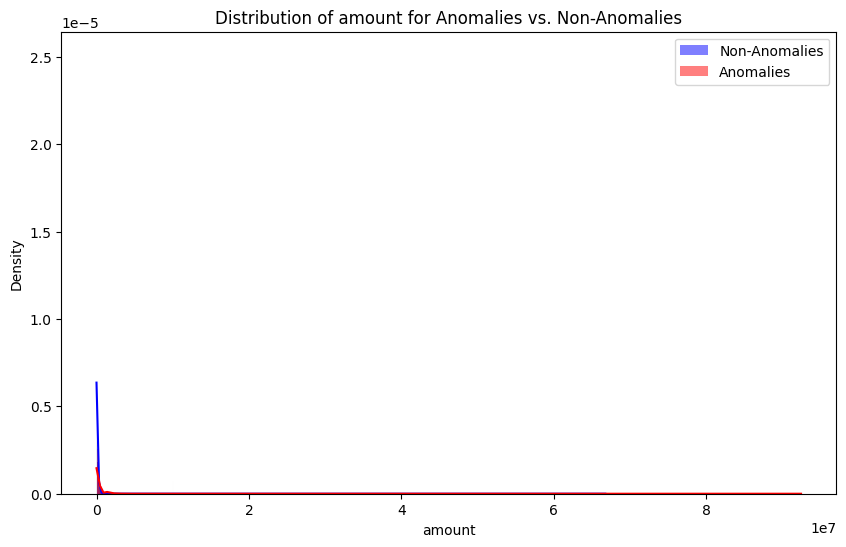

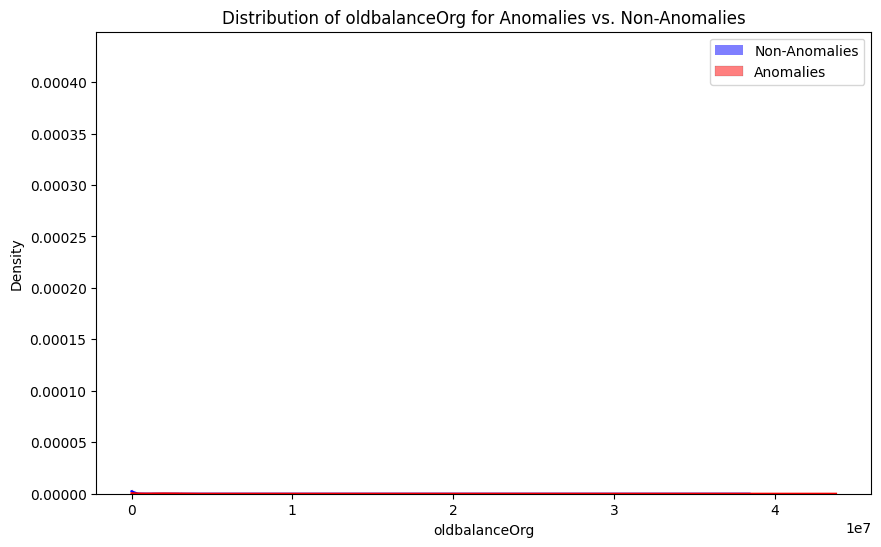

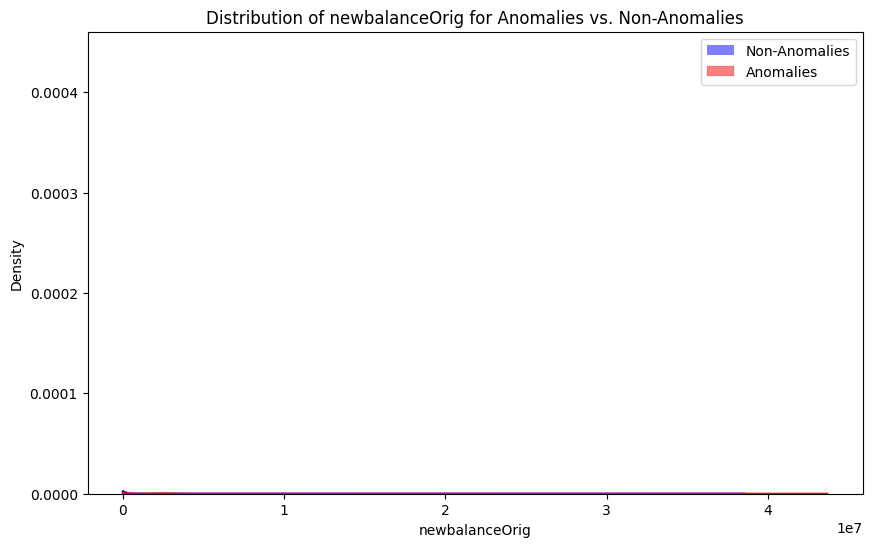

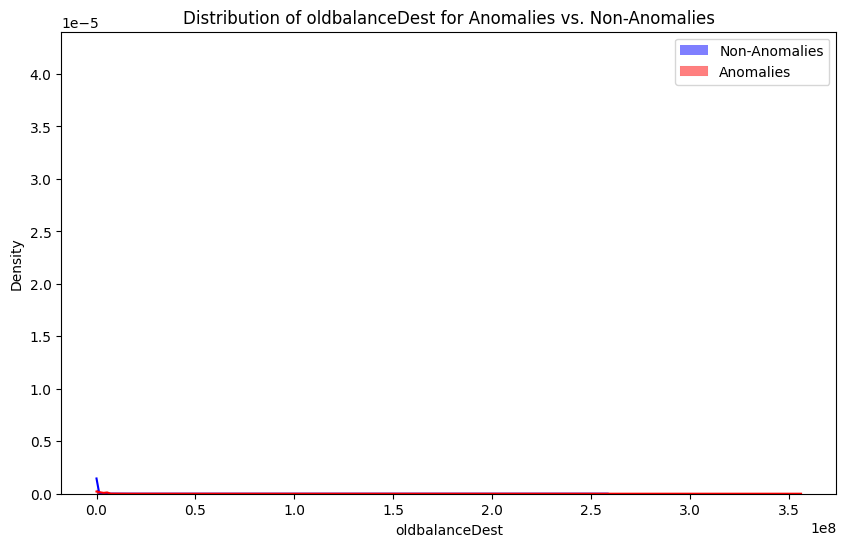

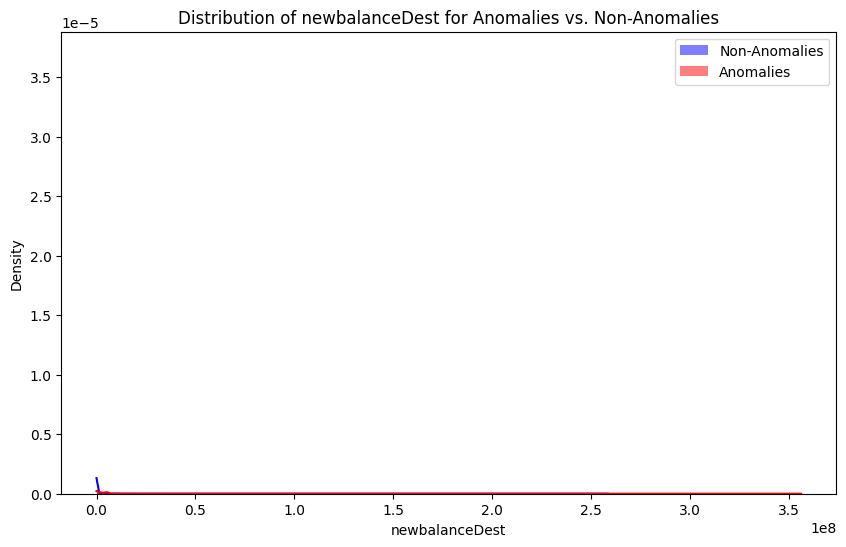

In [55]:
# Select a threshold and identify anomalies
anom_threshold = -0.1
anomalies = anomaly_scores < anom_threshold

# Extract anomalies
anomalies_df = pd.DataFrame(scaler.inverse_transform(X_scaled[anomalies]), columns=numerical_features)

# Print the first few anomalies for review
print(anomalies_df.head())

# Add a column to the original DataFrame to indicate whether a row is an anomaly
df_synt['isAnomaly'] = False
df_synt.loc[anomalies, 'isAnomaly'] = True

# Compare feature distributions
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_synt[df_synt['isAnomaly'] == False][feature], color='blue', label='Non-Anomalies', kde=True, stat='density')
    sns.histplot(df_synt[df_synt['isAnomaly'] == True][feature], color='red', label='Anomalies', kde=True, stat='density')
    plt.title(f'Distribution of {feature} for Anomalies vs. Non-Anomalies')
    plt.legend()
    plt.show()


In [57]:
df_synt.tail()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,balance_delta,large_transaction,Anomaly,isAnomaly
6362609,742,258355.42,C1113162093,258355.42,0.0,C797688696,25176.67,283532.09,1,0,22,False,True,False,False,False,258355.42,True,0,False
6362611,742,63416.99,C994950684,63416.99,0.0,C1662241365,276433.18,339850.17,1,0,22,False,True,False,False,False,63416.99,False,0,False
6362613,743,1258818.82,C1436118706,1258818.82,0.0,C1240760502,503464.50,1762283.33,1,0,23,False,True,False,False,False,1258818.82,True,1,True
6362617,743,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0,23,False,True,False,False,False,6311409.28,True,1,True
6362619,743,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0,23,False,True,False,False,False,850002.52,True,0,False


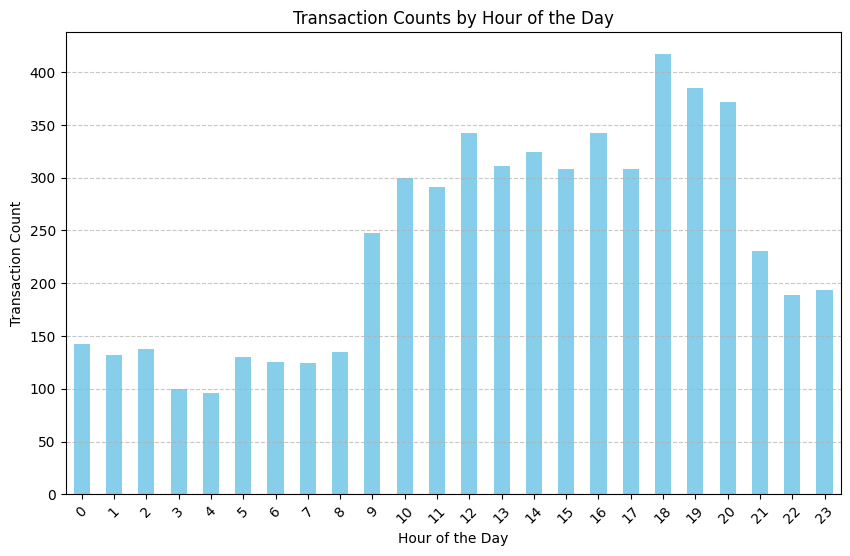

In [144]:
# Aggregate transaction counts by hour
transaction_counts_by_hour = df_synt.groupby('hour').size()

# Visualize transaction counts by hour
plt.figure(figsize=(10, 6))
transaction_counts_by_hour.plot(kind='bar', color='skyblue')
plt.title('Transaction Counts by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [139]:
# Filter transactions between hours 10 and 20
hourly_transactions = df_synt[(df_synt['hour'] >= 10) & (df_synt['hour'] <= 20)]

# Group transactions by hour and transaction type
hourly_transaction_counts = hourly_transactions.groupby(['hour', 'type']).size().unstack(fill_value=0)

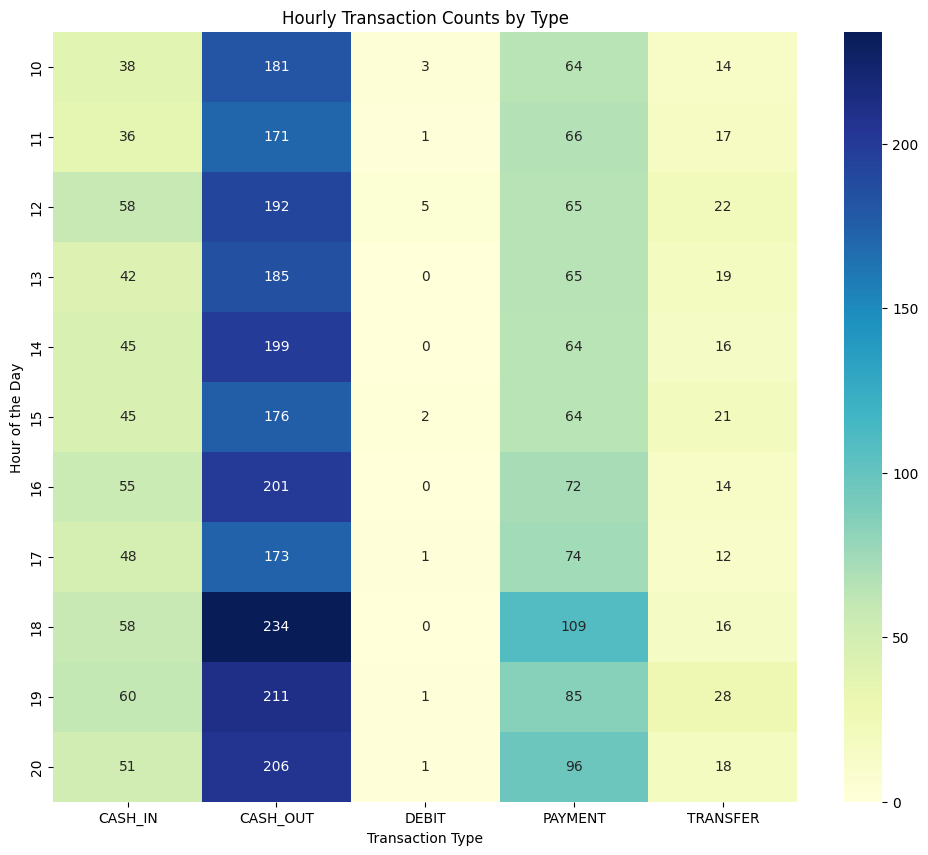

In [140]:
# Plot transaction counts by hour and type
plt.figure(figsize=(12, 10))
sns.heatmap(hourly_transaction_counts, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Hourly Transaction Counts by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Hour of the Day')
plt.show()

In [141]:
# Check for the peak hour
peak_hour = hourly_transaction_counts.sum(axis=1).idxmax()
print(f"The peak hour of transaction volume is {peak_hour}")

The peak hour of transaction volume is 18


In [143]:
# Investigate the transactions during the peak hour
peak_hour_transactions = hourly_transactions[hourly_transactions['hour'] == peak_hour]
print("Peak Hour Transactions:")
peak_hour_transactions.head()

Peak Hour Transactions:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,balance_delta,large_transaction,Anomaly
1,210,TRANSFER,182417.23,2343,0.00,0.00,862,1002955.42,1185372.65,0,0,18,0.00,False,1
19,306,CASH_IN,290933.94,427,991558.67,1282492.61,2403,1613736.29,1322802.35,0,0,18,-290933.94,True,0
30,234,PAYMENT,5879.65,3525,0.00,0.00,5204,0.00,0.00,0,0,18,0.00,False,0
33,570,CASH_OUT,1131750.38,1161,1131750.38,0.00,1460,313070.53,1444820.92,1,0,18,1131750.38,True,0
37,330,PAYMENT,18325.83,5048,0.00,0.00,5493,0.00,0.00,0,0,18,0.00,False,0
